In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
"""
lab_utils_common
   contains common routines and variable definitions
   used by all the labs in this week.
   by contrast, specific, large plotting routines will be in separate files
   and are generally imported into the week where they are used.
   those files will import this file
"""
import copy
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from ipywidgets import Output

np.set_printoptions(precision=2)

dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]
plt.style.use('/content/drive/MyDrive/Coursera/deeplearning.mplstyle')

def sigmoid(z):
    """
    Compute the sigmoid of z

    Parameters
    ----------
    z : array_like
        A scalar or numpy array of any size.

    Returns
    -------
     g : array_like
         sigmoid(z)
    """
    z = np.clip( z, -500, 500 )           # protect against overflow
    g = 1.0/(1.0+np.exp(-z))

    return g

##########################################################
# Regression Routines
##########################################################

def predict_logistic(X, w, b):
    """ performs prediction """
    return sigmoid(X @ w + b)

def predict_linear(X, w, b):
    """ performs prediction """
    return X @ w + b

def compute_cost_logistic(X, y, w, b, lambda_=0, safe=False):
    """
    Computes cost using logistic loss, non-matrix version

    Args:
      X (ndarray): Shape (m,n)  matrix of examples with n features
      y (ndarray): Shape (m,)   target values
      w (ndarray): Shape (n,)   parameters for prediction
      b (scalar):               parameter  for prediction
      lambda_ : (scalar, float) Controls amount of regularization, 0 = no regularization
      safe : (boolean)          True-selects under/overflow safe algorithm
    Returns:
      cost (scalar): cost
    """

    m,n = X.shape
    cost = 0.0
    for i in range(m):
        z_i    = np.dot(X[i],w) + b                                             #(n,)(n,) or (n,) ()
        if safe:  #avoids overflows
            cost += -(y[i] * z_i ) + log_1pexp(z_i)
        else:
            f_wb_i = sigmoid(z_i)                                                   #(n,)
            cost  += -y[i] * np.log(f_wb_i) - (1 - y[i]) * np.log(1 - f_wb_i)       # scalar
    cost = cost/m

    reg_cost = 0
    if lambda_ != 0:
        for j in range(n):
            reg_cost += (w[j]**2)                                               # scalar
        reg_cost = (lambda_/(2*m))*reg_cost

    return cost + reg_cost


def log_1pexp(x, maximum=20):
    ''' approximate log(1+exp^x)
        https://stats.stackexchange.com/questions/475589/numerical-computation-of-cross-entropy-in-practice
    Args:
    x   : (ndarray Shape (n,1) or (n,)  input
    out : (ndarray Shape matches x      output ~= np.log(1+exp(x))
    '''

    out  = np.zeros_like(x,dtype=float)
    i    = x <= maximum
    ni   = np.logical_not(i)

    out[i]  = np.log(1 + np.exp(x[i]))
    out[ni] = x[ni]
    return out


def compute_cost_matrix(X, y, w, b, logistic=False, lambda_=0, safe=True):
    """
    Computes the cost using  using matrices
    Args:
      X : (ndarray, Shape (m,n))          matrix of examples
      y : (ndarray  Shape (m,) or (m,1))  target value of each example
      w : (ndarray  Shape (n,) or (n,1))  Values of parameter(s) of the model
      b : (scalar )                       Values of parameter of the model
      verbose : (Boolean) If true, print out intermediate value f_wb
    Returns:
      total_cost: (scalar)                cost
    """
    m = X.shape[0]
    y = y.reshape(-1,1)             # ensure 2D
    w = w.reshape(-1,1)             # ensure 2D
    if logistic:
        if safe:  #safe from overflow
            z = X @ w + b                                                           #(m,n)(n,1)=(m,1)
            cost = -(y * z) + log_1pexp(z)
            cost = np.sum(cost)/m                                                   # (scalar)
        else:
            f    = sigmoid(X @ w + b)                                               # (m,n)(n,1) = (m,1)
            cost = (1/m)*(np.dot(-y.T, np.log(f)) - np.dot((1-y).T, np.log(1-f)))   # (1,m)(m,1) = (1,1)
            cost = cost[0,0]                                                        # scalar
    else:
        f    = X @ w + b                                                        # (m,n)(n,1) = (m,1)
        cost = (1/(2*m)) * np.sum((f - y)**2)                                   # scalar

    reg_cost = (lambda_/(2*m)) * np.sum(w**2)                                   # scalar

    total_cost = cost + reg_cost                                                # scalar

    return total_cost                                                           # scalar

def compute_gradient_matrix(X, y, w, b, logistic=False, lambda_=0):
    """
    Computes the gradient using matrices

    Args:
      X : (ndarray, Shape (m,n))          matrix of examples
      y : (ndarray  Shape (m,) or (m,1))  target value of each example
      w : (ndarray  Shape (n,) or (n,1))  Values of parameters of the model
      b : (scalar )                       Values of parameter of the model
      logistic: (boolean)                 linear if false, logistic if true
      lambda_:  (float)                   applies regularization if non-zero
    Returns
      dj_dw: (array_like Shape (n,1))     The gradient of the cost w.r.t. the parameters w
      dj_db: (scalar)                     The gradient of the cost w.r.t. the parameter b
    """
    m = X.shape[0]
    y = y.reshape(-1,1)             # ensure 2D
    w = w.reshape(-1,1)             # ensure 2D

    f_wb  = sigmoid( X @ w + b ) if logistic else  X @ w + b      # (m,n)(n,1) = (m,1)
    err   = f_wb - y                                              # (m,1)
    dj_dw = (1/m) * (X.T @ err)                                   # (n,m)(m,1) = (n,1)
    dj_db = (1/m) * np.sum(err)                                   # scalar

    dj_dw += (lambda_/m) * w        # regularize                  # (n,1)

    return dj_db, dj_dw                                           # scalar, (n,1)

def gradient_descent(X, y, w_in, b_in, alpha, num_iters, logistic=False, lambda_=0, verbose=True):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X (ndarray):    Shape (m,n)         matrix of examples
      y (ndarray):    Shape (m,) or (m,1) target value of each example
      w_in (ndarray): Shape (n,) or (n,1) Initial values of parameters of the model
      b_in (scalar):                      Initial value of parameter of the model
      logistic: (boolean)                 linear if false, logistic if true
      lambda_:  (float)                   applies regularization if non-zero
      alpha (float):                      Learning rate
      num_iters (int):                    number of iterations to run gradient descent

    Returns:
      w (ndarray): Shape (n,) or (n,1)    Updated values of parameters; matches incoming shape
      b (scalar):                         Updated value of parameter
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    w = w.reshape(-1,1)      #prep for matrix operations
    y = y.reshape(-1,1)

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = compute_gradient_matrix(X, y, w, b, logistic, lambda_)

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history.append( compute_cost_matrix(X, y, w, b, logistic, lambda_) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            if verbose: print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")

    return w.reshape(w_in.shape), b, J_history  #return final w,b and J history for graphing

def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column

    Args:
      X (ndarray): Shape (m,n) input 
     , m examples, n features

    Returns:
      X_norm (ndarray): Shape (m,n)  input normalized by column
      mu (ndarray):     Shape (n,)   mean of each feature
      sigma (ndarray):  Shape (n,)   standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

#check our work
#from sklearn.preprocessing import scale
#scale(X_orig, axis=0, with_mean=True, with_std=True, copy=True)

######################################################
# Common Plotting Routines
######################################################


def plot_data(X, y, ax, pos_label="y=1", neg_label="y=0", s=80, loc='best' ):
    """ plots logistic data with two axis """
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0
    pos = pos.reshape(-1,)  #work with 1D or 1D y vectors
    neg = neg.reshape(-1,)

    # Plot examples
    ax.scatter(X[pos, 0], X[pos, 1], marker='x', s=s, c = 'red', label=pos_label)
    ax.scatter(X[neg, 0], X[neg, 1], marker='o', s=s, label=neg_label, facecolors='none', edgecolors=dlblue, lw=3)
    ax.legend(loc=loc)

    ax.figure.canvas.toolbar_visible = False
    ax.figure.canvas.header_visible = False
    ax.figure.canvas.footer_visible = False

def plt_tumor_data(x, y, ax):
    """ plots tumor data on one axis """
    pos = y == 1
    neg = y == 0

    ax.scatter(x[pos], y[pos], marker='x', s=80, c = 'red', label="malignant")
    ax.scatter(x[neg], y[neg], marker='o', s=100, label="benign", facecolors='none', edgecolors=dlblue,lw=3)
    ax.set_ylim(-0.175,1.1)
    ax.set_ylabel('y')
    ax.set_xlabel('Tumor Size')
    ax.set_title("Logistic Regression on Categorical Data")

    ax.figure.canvas.toolbar_visible = False
    ax.figure.canvas.header_visible = False
    ax.figure.canvas.footer_visible = False

# Draws a threshold at 0.5
def draw_vthresh(ax,x):
    """ draws a threshold """
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    ax.fill_between([xlim[0], x], [ylim[1], ylim[1]], alpha=0.2, color=dlblue)
    ax.fill_between([x, xlim[1]], [ylim[1], ylim[1]], alpha=0.2, color=dldarkred)
    ax.annotate("z >= 0", xy= [x,0.5], xycoords='data',
                xytext=[30,5],textcoords='offset points')
    d = FancyArrowPatch(
        posA=(x, 0.5), posB=(x+3, 0.5), color=dldarkred,
        arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
    )
    ax.add_artist(d)
    ax.annotate("z < 0", xy= [x,0.5], xycoords='data',
                 xytext=[-50,5],textcoords='offset points', ha='left')
    f = FancyArrowPatch(
        posA=(x, 0.5), posB=(x-3, 0.5), color=dlblue,
        arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
    )
    ax.add_artist(f)


In [3]:
""" 
lab_utils_uni.py
    routines used in Course 1, Week2, labs1-3 dealing with single variables (univariate)
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from ipywidgets import interact
#from lab_utils_common import compute_cost
#from lab_utils_common import dlblue, dlorange, dldarkred, dlmagenta, dlpurple, dlcolors

plt.style.use('/content/drive/MyDrive/Coursera/deeplearning.mplstyle')
n_bin = 5
dlcm = LinearSegmentedColormap.from_list(
        'dl_map', dlcolors, N=n_bin)

##########################################################
# Plotting Routines
##########################################################

def plt_house_x(X, y,f_wb=None, ax=None):
    ''' plot house with aXis '''
    if not ax:
        fig, ax = plt.subplots(1,1)
    ax.scatter(X, y, marker='x', c='r', label="Actual Value")

    ax.set_title("Housing Prices")
    ax.set_ylabel('Price (in 1000s of dollars)')
    ax.set_xlabel(f'Size (1000 sqft)')
    if f_wb is not None:
        ax.plot(X, f_wb,  c=dlblue, label="Our Prediction")
    ax.legend()


def mk_cost_lines(x,y,w,b, ax):
    ''' makes vertical cost lines'''
    cstr = "cost = (1/m)*("
    ctot = 0
    label = 'cost for point'
    addedbreak = False
    for p in zip(x,y):
        f_wb_p = w*p[0]+b
        c_p = ((f_wb_p - p[1])**2)/2
        c_p_txt = c_p
        ax.vlines(p[0], p[1],f_wb_p, lw=3, color=dlpurple, ls='dotted', label=label)
        label='' #just one
        cxy = [p[0], p[1] + (f_wb_p-p[1])/2]
        ax.annotate(f'{c_p_txt:0.0f}', xy=cxy, xycoords='data',color=dlpurple,
            xytext=(5, 0), textcoords='offset points')
        cstr += f"{c_p_txt:0.0f} +"
        if len(cstr) > 38 and addedbreak is False:
            cstr += "\n"
            addedbreak = True
        ctot += c_p
    ctot = ctot/(len(x))
    cstr = cstr[:-1] + f") = {ctot:0.0f}"
    ax.text(0.15,0.02,cstr, transform=ax.transAxes, color=dlpurple)

##########
# Cost lab
##########


def plt_intuition(x_train, y_train):

    w_range = np.array([200-200,200+200])
    tmp_b = 100

    w_array = np.arange(*w_range, 5)
    cost = np.zeros_like(w_array)
    for i in range(len(w_array)):
        tmp_w = w_array[i]
        cost[i] = compute_cost(x_train, y_train, tmp_w, tmp_b)

    @interact(w=(*w_range,10),continuous_update=False)
    def func( w=150):
        f_wb = np.dot(x_train, w) + tmp_b

        fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(8,4))
        fig.canvas.toolbar_position = 'bottom'

        mk_cost_lines(x_train, y_train, w, tmp_b, ax[0])
        plt_house_x(x_train, y_train, f_wb=f_wb, ax=ax[0])

        ax[1].plot(w_array, cost)
        cur_cost = compute_cost(x_train, y_train, w, tmp_b)
        ax[1].scatter(w,cur_cost, s=100, color=dldarkred, zorder= 10, label= f"cost at w={w}")
        ax[1].hlines(cur_cost, ax[1].get_xlim()[0],w, lw=4, color=dlpurple, ls='dotted')
        ax[1].vlines(w, ax[1].get_ylim()[0],cur_cost, lw=4, color=dlpurple, ls='dotted')
        ax[1].set_title("Cost vs. w, (b fixed at 100)")
        ax[1].set_ylabel('Cost')
        ax[1].set_xlabel('w')
        ax[1].legend(loc='upper center')
        fig.suptitle(f"Minimize Cost: Current Cost = {cur_cost:0.0f}", fontsize=12)
        plt.show()

# this is the 2D cost curve with interactive slider
def plt_stationary(x_train, y_train):
    # setup figure
    fig = plt.figure( figsize=(9,8))
    #fig = plt.figure(constrained_layout=True,  figsize=(12,10))
    fig.set_facecolor('#ffffff') #white
    fig.canvas.toolbar_position = 'top'
    #gs = GridSpec(2, 2, figure=fig, wspace = 0.01)
    gs = GridSpec(2, 2, figure=fig)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, :],  projection='3d')
    ax = np.array([ax0,ax1,ax2])

    #setup useful ranges and common linspaces
    w_range = np.array([200-300.,200+300])
    b_range = np.array([50-300., 50+300])
    b_space  = np.linspace(*b_range, 100)
    w_space  = np.linspace(*w_range, 100)

    # get cost for w,b ranges for contour and 3D
    tmp_b,tmp_w = np.meshgrid(b_space,w_space)
    z=np.zeros_like(tmp_b)
    for i in range(tmp_w.shape[0]):
        for j in range(tmp_w.shape[1]):
            z[i,j] = compute_cost(x_train, y_train, tmp_w[i][j], tmp_b[i][j] )
            if z[i,j] == 0: z[i,j] = 1e-6

    w0=200;b=-100    #initial point
    ### plot model w cost ###
    f_wb = np.dot(x_train,w0) + b
    mk_cost_lines(x_train,y_train,w0,b,ax[0])
    plt_house_x(x_train, y_train, f_wb=f_wb, ax=ax[0])

    ### plot contour ###
    CS = ax[1].contour(tmp_w, tmp_b, np.log(z),levels=12, linewidths=2, alpha=0.7,colors=dlcolors)
    ax[1].set_title('Cost(w,b)')
    ax[1].set_xlabel('w', fontsize=10)
    ax[1].set_ylabel('b', fontsize=10)
    ax[1].set_xlim(w_range) ; ax[1].set_ylim(b_range)
    cscat  = ax[1].scatter(w0,b, s=100, color=dlblue, zorder= 10, label="cost with \ncurrent w,b")
    chline = ax[1].hlines(b, ax[1].get_xlim()[0],w0, lw=4, color=dlpurple, ls='dotted')
    cvline = ax[1].vlines(w0, ax[1].get_ylim()[0],b, lw=4, color=dlpurple, ls='dotted')
    ax[1].text(0.5,0.95,"Click to choose w,b",  bbox=dict(facecolor='white', ec = 'black'), fontsize = 10,
                transform=ax[1].transAxes, verticalalignment = 'center', horizontalalignment= 'center')

    #Surface plot of the cost function J(w,b)
    ax[2].plot_surface(tmp_w, tmp_b, z,  cmap = dlcm, alpha=0.3, antialiased=True)
    ax[2].plot_wireframe(tmp_w, tmp_b, z, color='k', alpha=0.1)
    plt.xlabel("$w$")
    plt.ylabel("$b$")
    ax[2].zaxis.set_rotate_label(False)
    ax[2].xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax[2].yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax[2].zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax[2].set_zlabel("J(w, b)\n\n", rotation=90)
    plt.title("Cost(w,b) \n [You can rotate this figure]", size=12)
    ax[2].view_init(30, -120)

    return fig,ax, [cscat, chline, cvline]


#https://matplotlib.org/stable/users/event_handling.html
class plt_update_onclick:
    def __init__(self, fig, ax, x_train,y_train, dyn_items):
        self.fig = fig
        self.ax = ax
        self.x_train = x_train
        self.y_train = y_train
        self.dyn_items = dyn_items
        self.cid = fig.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        if event.inaxes == self.ax[1]:
            ws = event.xdata
            bs = event.ydata
            cst = compute_cost(self.x_train, self.y_train, ws, bs)

            # clear and redraw line plot
            self.ax[0].clear()
            f_wb = np.dot(self.x_train,ws) + bs
            mk_cost_lines(self.x_train,self.y_train,ws,bs,self.ax[0])
            plt_house_x(self.x_train, self.y_train, f_wb=f_wb, ax=self.ax[0])

            # remove lines and re-add on countour plot and 3d plot
            for artist in self.dyn_items:
                artist.remove()

            a = self.ax[1].scatter(ws,bs, s=100, color=dlblue, zorder= 10, label="cost with \ncurrent w,b")
            b = self.ax[1].hlines(bs, self.ax[1].get_xlim()[0],ws, lw=4, color=dlpurple, ls='dotted')
            c = self.ax[1].vlines(ws, self.ax[1].get_ylim()[0],bs, lw=4, color=dlpurple, ls='dotted')
            d = self.ax[1].annotate(f"Cost: {cst:.0f}", xy= (ws, bs), xytext = (4,4), textcoords = 'offset points',
                               bbox=dict(facecolor='white'), size = 10)

            #Add point in 3D surface plot
            e = self.ax[2].scatter3D(ws, bs,cst , marker='X', s=100)

            self.dyn_items = [a,b,c,d,e]
            self.fig.canvas.draw()


def soup_bowl():
    """ Create figure and plot with a 3D projection"""
    fig = plt.figure(figsize=(8,8))

    #Plot configuration
    ax = fig.add_subplot(111, projection='3d')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_rotate_label(False)
    ax.view_init(45, -120)

    #Useful linearspaces to give values to the parameters w and b
    w = np.linspace(-20, 20, 100)
    b = np.linspace(-20, 20, 100)

    #Get the z value for a bowl-shaped cost function
    z=np.zeros((len(w), len(b)))
    j=0
    for x in w:
        i=0
        for y in b:
            z[i,j] = x**2 + y**2
            i+=1
        j+=1

    #Meshgrid used for plotting 3D functions
    W, B = np.meshgrid(w, b)

    #Create the 3D surface plot of the bowl-shaped cost function
    ax.plot_surface(W, B, z, cmap = "Spectral_r", alpha=0.7, antialiased=False)
    ax.plot_wireframe(W, B, z, color='k', alpha=0.1)
    ax.set_xlabel("$w$")
    ax.set_ylabel("$b$")
    ax.set_zlabel("$J(w,b)$", rotation=90)
    ax.set_title("$J(w,b)$\n [You can rotate this figure]", size=15)

    plt.show()

def inbounds(a,b,xlim,ylim):
    xlow,xhigh = xlim
    ylow,yhigh = ylim
    ax, ay = a
    bx, by = b
    if (ax > xlow and ax < xhigh) and (bx > xlow and bx < xhigh) \
        and (ay > ylow and ay < yhigh) and (by > ylow and by < yhigh):
        return True
    return False

def plt_contour_wgrad(x, y, hist, ax, w_range=[-100, 500, 5], b_range=[-500, 500, 5],
                contours = [0.1,50,1000,5000,10000,25000,50000],
                      resolution=5, w_final=200, b_final=100,step=10 ):
    b0,w0 = np.meshgrid(np.arange(*b_range),np.arange(*w_range))
    z=np.zeros_like(b0)
    for i in range(w0.shape[0]):
        for j in range(w0.shape[1]):
            z[i][j] = compute_cost(x, y, w0[i][j], b0[i][j] )

    CS = ax.contour(w0, b0, z, contours, linewidths=2,
                   colors=[dlblue, dlorange, dldarkred, dlmagenta, dlpurple])
    ax.clabel(CS, inline=1, fmt='%1.0f', fontsize=10)
    ax.set_xlabel("w");  ax.set_ylabel("b")
    ax.set_title('Contour plot of cost J(w,b), vs b,w with path of gradient descent')
    w = w_final; b=b_final
    ax.hlines(b, ax.get_xlim()[0],w, lw=2, color=dlpurple, ls='dotted')
    ax.vlines(w, ax.get_ylim()[0],b, lw=2, color=dlpurple, ls='dotted')

    base = hist[0]
    for point in hist[0::step]:
        edist = np.sqrt((base[0] - point[0])**2 + (base[1] - point[1])**2)
        if(edist > resolution or point==hist[-1]):
            if inbounds(point,base, ax.get_xlim(),ax.get_ylim()):
                plt.annotate('', xy=point, xytext=base,xycoords='data',
                         arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 3},
                         va='center', ha='center')
            base=point
    return


def plt_divergence(p_hist, J_hist, x_train,y_train):

    x=np.zeros(len(p_hist))
    y=np.zeros(len(p_hist))
    v=np.zeros(len(p_hist))
    for i in range(len(p_hist)):
        x[i] = p_hist[i][0]
        y[i] = p_hist[i][1]
        v[i] = J_hist[i]

    fig = plt.figure(figsize=(12,5))
    plt.subplots_adjust( wspace=0 )
    gs = fig.add_gridspec(1, 5)
    fig.suptitle(f"Cost escalates when learning rate is too large")
    #===============
    #  First subplot
    #===============
    ax = fig.add_subplot(gs[:2], )

    # Print w vs cost to see minimum
    fix_b = 100
    w_array = np.arange(-70000, 70000, 1000)
    cost = np.zeros_like(w_array)

    for i in range(len(w_array)):
        tmp_w = w_array[i]
        cost[i] = compute_cost(x_train, y_train, tmp_w, fix_b)

    ax.plot(w_array, cost)
    ax.plot(x,v, c=dlmagenta)
    ax.set_title("Cost vs w, b set to 100")
    ax.set_ylabel('Cost')
    ax.set_xlabel('w')
    ax.xaxis.set_major_locator(MaxNLocator(2))

    #===============
    # Second Subplot
    #===============

    tmp_b,tmp_w = np.meshgrid(np.arange(-35000, 35000, 500),np.arange(-70000, 70000, 500))
    z=np.zeros_like(tmp_b)
    for i in range(tmp_w.shape[0]):
        for j in range(tmp_w.shape[1]):
            z[i][j] = compute_cost(x_train, y_train, tmp_w[i][j], tmp_b[i][j] )

    ax = fig.add_subplot(gs[2:], projection='3d')
    ax.plot_surface(tmp_w, tmp_b, z,  alpha=0.3, color=dlblue)
    ax.xaxis.set_major_locator(MaxNLocator(2))
    ax.yaxis.set_major_locator(MaxNLocator(2))

    ax.set_xlabel('w', fontsize=16)
    ax.set_ylabel('b', fontsize=16)
    ax.set_zlabel('\ncost', fontsize=16)
    plt.title('Cost vs (b, w)')
    # Customize the view angle
    ax.view_init(elev=20., azim=-65)
    ax.plot(x, y, v,c=dlmagenta)

    return

# draw derivative line
# y = m*(x - x1) + y1
def add_line(dj_dx, x1, y1, d, ax):
    x = np.linspace(x1-d, x1+d,50)
    y = dj_dx*(x - x1) + y1
    ax.scatter(x1, y1, color=dlblue, s=50)
    ax.plot(x, y, '--', c=dldarkred,zorder=10, linewidth = 1)
    xoff = 30 if x1 == 200 else 10
    ax.annotate(r"$\frac{\partial J}{\partial w}$ =%d" % dj_dx, fontsize=14,
                xy=(x1, y1), xycoords='data',
            xytext=(xoff, 10), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"),
            horizontalalignment='left', verticalalignment='top')

def plt_gradients(x_train,y_train, f_compute_cost, f_compute_gradient):
    #===============
    #  First subplot
    #===============
    fig,ax = plt.subplots(1,2,figsize=(12,4))

    # Print w vs cost to see minimum
    fix_b = 100
    w_array = np.linspace(-100, 500, 50)
    w_array = np.linspace(0, 400, 50)
    cost = np.zeros_like(w_array)

    for i in range(len(w_array)):
        tmp_w = w_array[i]
        cost[i] = f_compute_cost(x_train, y_train, tmp_w, fix_b)
    ax[0].plot(w_array, cost,linewidth=1)
    ax[0].set_title("Cost vs w, with gradient; b set to 100")
    ax[0].set_ylabel('Cost')
    ax[0].set_xlabel('w')

    # plot lines for fixed b=100
    for tmp_w in [100,200,300]:
        fix_b = 100
        dj_dw,dj_db = f_compute_gradient(x_train, y_train, tmp_w, fix_b )
        j = f_compute_cost(x_train, y_train, tmp_w, fix_b)
        add_line(dj_dw, tmp_w, j, 30, ax[0])

    #===============
    # Second Subplot
    #===============

    tmp_b,tmp_w = np.meshgrid(np.linspace(-200, 200, 10), np.linspace(-100, 600, 10))
    U = np.zeros_like(tmp_w)
    V = np.zeros_like(tmp_b)
    for i in range(tmp_w.shape[0]):
        for j in range(tmp_w.shape[1]):
            U[i][j], V[i][j] = f_compute_gradient(x_train, y_train, tmp_w[i][j], tmp_b[i][j] )
    X = tmp_w
    Y = tmp_b
    n=-2
    color_array = np.sqrt(((V-n)/2)**2 + ((U-n)/2)**2)

    ax[1].set_title('Gradient shown in quiver plot')
    Q = ax[1].quiver(X, Y, U, V, color_array, units='width', )
    ax[1].quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',coordinates='figure')
    ax[1].set_xlabel("w"); ax[1].set_ylabel("b")

In [4]:
# plt_one_addpt_onclick.py

import time
import copy
from ipywidgets import Output
from matplotlib.widgets import Button, CheckButtons
from matplotlib.patches import FancyArrowPatch

# for debug
#output = Output() # sends hidden error messages to display when using widgets
#display(output)

class plt_one_addpt_onclick:
    """ class to run one interactive plot """
    def __init__(self, x, y, w, b, logistic=True):
        self.logistic=logistic
        pos = y == 1
        neg = y == 0

        fig,ax = plt.subplots(1,1,figsize=(8,4))
        fig.canvas.toolbar_visible = False
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False

        plt.subplots_adjust(bottom=0.25)
        ax.scatter(x[pos], y[pos], marker='x', s=80, c = 'red', label="malignant")
        ax.scatter(x[neg], y[neg], marker='o', s=100, label="benign", facecolors='none', edgecolors=dlblue,lw=3)
        ax.set_ylim(-0.05,1.1)
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[0],xlim[1]*2)
        ax.set_ylabel('y')
        ax.set_xlabel('Tumor Size')
        self.alegend = ax.legend(loc='lower right')
        if self.logistic:
            ax.set_title("Example of Logistic Regression on Categorical Data")
        else:
            ax.set_title("Example of Linear Regression on Categorical Data")

        ax.text(0.65,0.8,"[Click to add data points]", size=10, transform=ax.transAxes)

        axcalc   = plt.axes([0.1, 0.05, 0.38, 0.075])  #l,b,w,h
        axthresh = plt.axes([0.5, 0.05, 0.38, 0.075])  #l,b,w,h
        self.tlist = []

        self.fig = fig
        self.ax = [ax,axcalc,axthresh]
        self.x = x
        self.y = y
        self.w = copy.deepcopy(w)
        self.b = b
        f_wb = np.matmul(self.x.reshape(-1,1), self.w) + self.b
        if self.logistic:
            self.aline = self.ax[0].plot(self.x, sigmoid(f_wb), color=dlblue)
            self.bline = self.ax[0].plot(self.x, f_wb, color=dlorange,lw=1)
        else:
            self.aline = self.ax[0].plot(self.x, sigmoid(f_wb), color=dlblue)

        self.cid = fig.canvas.mpl_connect('button_press_event', self.add_data)
        if self.logistic:
            self.bcalc = Button(axcalc, 'Run Logistic Regression (click)', color=dlblue)
            self.bcalc.on_clicked(self.calc_logistic)
        else:
            self.bcalc = Button(axcalc, 'Run Linear Regression (click)', color=dlblue)
            self.bcalc.on_clicked(self.calc_linear)
        self.bthresh = CheckButtons(axthresh, ('Toggle 0.5 threshold (after regression)',))
        self.bthresh.on_clicked(self.thresh)
        self.resize_sq(self.bthresh)

 #   @output.capture()  # debug
    def add_data(self, event):
        #self.ax[0].text(0.1,0.1, f"in onclick")
        if event.inaxes == self.ax[0]:
            x_coord = event.xdata
            y_coord = event.ydata

            if y_coord > 0.5:
                self.ax[0].scatter(x_coord, 1, marker='x', s=80, c = 'red' )
                self.y = np.append(self.y,1)
            else:
                self.ax[0].scatter(x_coord, 0, marker='o', s=100, facecolors='none', edgecolors=dlblue,lw=3)
                self.y = np.append(self.y,0)
            self.x = np.append(self.x,x_coord)
        self.fig.canvas.draw()

#   @output.capture()  # debug
    def calc_linear(self, event):
        if self.bthresh.get_status()[0]:
            self.remove_thresh()
        for it in [1,1,1,1,1,2,4,8,16,32,64,128,256]:
            self.w, self.b, _ = gradient_descent(self.x.reshape(-1,1), self.y.reshape(-1,1),
                                                 self.w.reshape(-1,1), self.b, 0.01, it,
                                                 logistic=False, lambda_=0, verbose=False)
            self.aline[0].remove()
            self.alegend.remove()
            y_hat = np.matmul(self.x.reshape(-1,1), self.w) + self.b
            self.aline = self.ax[0].plot(self.x, y_hat, color=dlblue,
                                         label=f"y = {np.squeeze(self.w):0.2f}x+({self.b:0.2f})")
            self.alegend = self.ax[0].legend(loc='lower right')
            time.sleep(0.3)
            self.fig.canvas.draw()
        if self.bthresh.get_status()[0]:
            self.draw_thresh()
            self.fig.canvas.draw()

    def calc_logistic(self, event):
        if self.bthresh.get_status()[0]:
            self.remove_thresh()
        for it in [1, 8,16,32,64,128,256,512,1024,2048,4096]:
            self.w, self.b, _ = gradient_descent(self.x.reshape(-1,1), self.y.reshape(-1,1),
                                                 self.w.reshape(-1,1), self.b, 0.1, it,
                                                 logistic=True, lambda_=0, verbose=False)
            self.aline[0].remove()
            self.bline[0].remove()
            self.alegend.remove()
            xlim  = self.ax[0].get_xlim()
            x_hat = np.linspace(*xlim, 30)
            y_hat = sigmoid(np.matmul(x_hat.reshape(-1,1), self.w) + self.b)
            self.aline = self.ax[0].plot(x_hat, y_hat, color=dlblue,
                                         label="y = sigmoid(z)")
            f_wb = np.matmul(x_hat.reshape(-1,1), self.w) + self.b
            self.bline = self.ax[0].plot(x_hat, f_wb, color=dlorange, lw=1,
                                         label=f"z = {np.squeeze(self.w):0.2f}x+({self.b:0.2f})")
            self.alegend = self.ax[0].legend(loc='lower right')
            time.sleep(0.3)
            self.fig.canvas.draw()
        if self.bthresh.get_status()[0]:
            self.draw_thresh()
            self.fig.canvas.draw()


    def thresh(self, event):
        if self.bthresh.get_status()[0]:
            #plt.figtext(0,0, f"in thresh {self.bthresh.get_status()}")
            self.draw_thresh()
        else:
            #plt.figtext(0,0.3, f"in thresh {self.bthresh.get_status()}")
            self.remove_thresh()

    def draw_thresh(self):
        ws = np.squeeze(self.w)
        xp5 = -self.b/ws if self.logistic else (0.5 - self.b) / ws
        ylim = self.ax[0].get_ylim()
        xlim = self.ax[0].get_xlim()
        a = self.ax[0].fill_between([xlim[0], xp5], [ylim[1], ylim[1]], alpha=0.2, color=dlblue)
        b = self.ax[0].fill_between([xp5, xlim[1]], [ylim[1], ylim[1]], alpha=0.2, color=dldarkred)
        c = self.ax[0].annotate("Malignant", xy= [xp5,0.5], xycoords='data',
             xytext=[30,5],textcoords='offset points')
        d = FancyArrowPatch(
            posA=(xp5, 0.5), posB=(xp5+1.5, 0.5), color=dldarkred,
            arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
        )
        self.ax[0].add_artist(d)

        e = self.ax[0].annotate("Benign", xy= [xp5,0.5], xycoords='data',
                     xytext=[-70,5],textcoords='offset points', ha='left')
        f = FancyArrowPatch(
            posA=(xp5, 0.5), posB=(xp5-1.5, 0.5), color=dlblue,
            arrowstyle='simple, head_width=5, head_length=10, tail_width=0.0',
        )
        self.ax[0].add_artist(f)
        self.tlist = [a,b,c,d,e,f]

        self.fig.canvas.draw()

    def remove_thresh(self):
        #plt.figtext(0.5,0.0, f"rem thresh {self.bthresh.get_status()}")
        for artist in self.tlist:
            artist.remove()
        self.fig.canvas.draw()

    def resize_sq(self, bcid):
        """ resizes the check box """
        #future reference
        #print(f"width  : {bcid.rectangles[0].get_width()}")
        #print(f"height : {bcid.rectangles[0].get_height()}")
        #print(f"xy     : {bcid.rectangles[0].get_xy()}")
        #print(f"bb     : {bcid.rectangles[0].get_bbox()}")
        #print(f"points : {bcid.rectangles[0].get_bbox().get_points()}")  #[[xmin,ymin],[xmax,ymax]]

        h = bcid.rectangles[0].get_height()
        bcid.rectangles[0].set_height(3*h)

        ymax = bcid.rectangles[0].get_bbox().y1
        ymin = bcid.rectangles[0].get_bbox().y0

        bcid.lines[0][0].set_ydata([ymax,ymin])
        bcid.lines[0][1].set_ydata([ymin,ymax])

In [5]:
# 3주차

In [6]:
# Classification

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
x_train = np.array([0., 1, 2, 3, 4, 5])
y_train = np.array([0,  0, 0, 1, 1, 1])
X_train2 = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_train2 = np.array([0, 0, 0, 1, 1, 1])

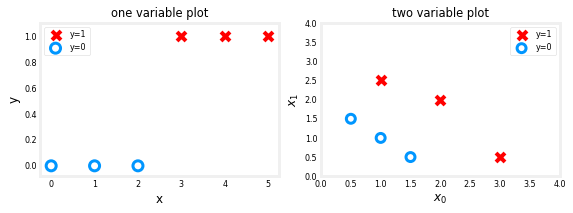

In [9]:
pos = y_train == 1
neg = y_train == 0

fig,ax = plt.subplots(1,2,figsize=(8,3))
#plot 1, single variable
ax[0].scatter(x_train[pos], y_train[pos], marker='x', s=80, c = 'red', label="y=1")
ax[0].scatter(x_train[neg], y_train[neg], marker='o', s=100, label="y=0", facecolors='none', 
              edgecolors=dlc["dlblue"],lw=3)

ax[0].set_ylim(-0.08,1.1)
ax[0].set_ylabel('y', fontsize=12)
ax[0].set_xlabel('x', fontsize=12)
ax[0].set_title('one variable plot')
ax[0].legend()

#plot 2, two variables
plot_data(X_train2, y_train2, ax[1])
ax[1].axis([0, 4, 0, 4])
ax[1].set_ylabel('$x_1$', fontsize=12)
ax[1].set_xlabel('$x_0$', fontsize=12)
ax[1].set_title('two variable plot')
ax[1].legend()
plt.tight_layout()
plt.show()

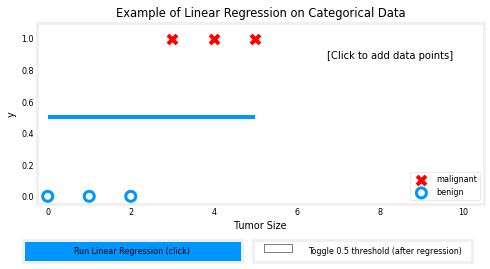

In [10]:
w_in = np.zeros((1))
b_in = 0
plt.close('all') 
addpt = plt_one_addpt_onclick( x_train,y_train, w_in, b_in, logistic=False)

In [11]:
# Logistic Regression

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Input is an array. 
input_array = np.array([1,2,3])
exp_array = np.exp(input_array)

print("Input to exp:", input_array)
print("Output of exp:", exp_array)

# Input is a single number
input_val = 1  
exp_val = np.exp(input_val)

print("Input to exp:", input_val)
print("Output of exp:", exp_val)

Input to exp: [1 2 3]
Output of exp: [ 2.72  7.39 20.09]
Input to exp: 1
Output of exp: 2.718281828459045


In [14]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """

    g = 1/(1+np.exp(-z))
   
    return g

In [15]:
# Generate an array of evenly spaced values between -10 and 10
z_tmp = np.arange(-10,11)

# Use the function implemented above to get the sigmoid values
y = sigmoid(z_tmp)

# Code for pretty printing the two arrays next to each other
np.set_printoptions(precision=3) 
print("Input (z), Output (sigmoid(z))")
print(np.c_[z_tmp, y])

Input (z), Output (sigmoid(z))
[[-1.000e+01  4.540e-05]
 [-9.000e+00  1.234e-04]
 [-8.000e+00  3.354e-04]
 [-7.000e+00  9.111e-04]
 [-6.000e+00  2.473e-03]
 [-5.000e+00  6.693e-03]
 [-4.000e+00  1.799e-02]
 [-3.000e+00  4.743e-02]
 [-2.000e+00  1.192e-01]
 [-1.000e+00  2.689e-01]
 [ 0.000e+00  5.000e-01]
 [ 1.000e+00  7.311e-01]
 [ 2.000e+00  8.808e-01]
 [ 3.000e+00  9.526e-01]
 [ 4.000e+00  9.820e-01]
 [ 5.000e+00  9.933e-01]
 [ 6.000e+00  9.975e-01]
 [ 7.000e+00  9.991e-01]
 [ 8.000e+00  9.997e-01]
 [ 9.000e+00  9.999e-01]
 [ 1.000e+01  1.000e+00]]


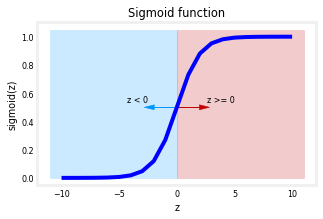

In [16]:
# Plot z vs sigmoid(z)
fig,ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(z_tmp, y, c="b")

ax.set_title("Sigmoid function")
ax.set_ylabel('sigmoid(z)')
ax.set_xlabel('z')
draw_vthresh(ax,0)

In [17]:
x_train = np.array([0., 1, 2, 3, 4, 5])
y_train = np.array([0,  0, 0, 1, 1, 1])

w_in = np.zeros((1))
b_in = 0

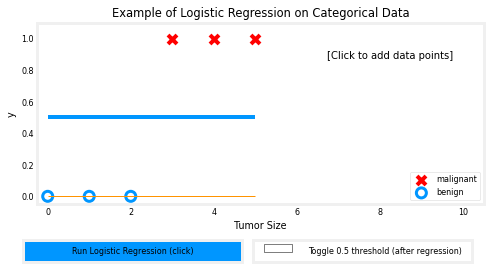

In [19]:
plt.close('all') 
addpt = plt_one_addpt_onclick( x_train,y_train, w_in, b_in, logistic=True)

In [20]:
# Decision Boundary

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
X = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y = np.array([0, 0, 0, 1, 1, 1]).reshape(-1,1) 

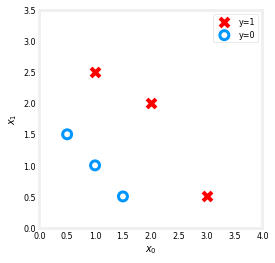

In [23]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_data(X, y, ax)

ax.axis([0, 4, 0, 3.5])
ax.set_ylabel('$x_1$')
ax.set_xlabel('$x_0$')
plt.show()

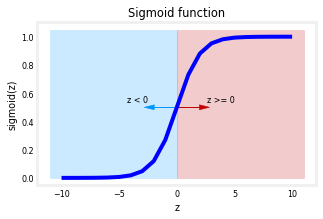

In [24]:
# Plot sigmoid(z) over a range of values from -10 to 10
z = np.arange(-10,11)

fig,ax = plt.subplots(1,1,figsize=(5,3))
# Plot z vs sigmoid(z)
ax.plot(z, sigmoid(z), c="b")

ax.set_title("Sigmoid function")
ax.set_ylabel('sigmoid(z)')
ax.set_xlabel('z')
draw_vthresh(ax,0)

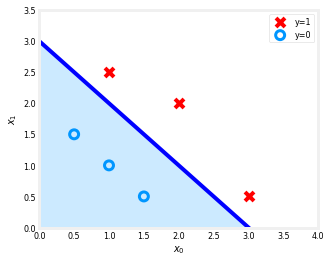

In [25]:
# Choose values between 0 and 6
x0 = np.arange(0,6)

x1 = 3 - x0
fig,ax = plt.subplots(1,1,figsize=(5,4))
# Plot the decision boundary
ax.plot(x0,x1, c="b")
ax.axis([0, 4, 0, 3.5])

# Fill the region below the line
ax.fill_between(x0,x1, alpha=0.2)

# Plot the original data
plot_data(X,y,ax)
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_0$')
plt.show()

In [26]:
# plt_logistic_loss.py

"""----------------------------------------------------------------
 logistic_loss plotting routines and support
"""

from matplotlib import cm

def compute_cost_logistic_sq_err(X, y, w, b):
    """
    compute sq error cost on logicist data (for negative example only, not used in practice)
    Args:
      X (ndarray): Shape (m,n) matrix of examples with multiple features
      w (ndarray): Shape (n)   parameters for prediction
      b (scalar):              parameter  for prediction
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        z_i = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z_i)                 #add sigmoid to normal sq error cost for linear regression
        cost = cost + (f_wb_i - y[i])**2
    cost = cost / (2 * m)
    return np.squeeze(cost)

def plt_logistic_squared_error(X,y):
    """ plots logistic squared error for demonstration """
    wx, by = np.meshgrid(np.linspace(-6,12,50),
                         np.linspace(10, -20, 40))
    points = np.c_[wx.ravel(), by.ravel()]
    cost = np.zeros(points.shape[0])

    for i in range(points.shape[0]):
        w,b = points[i]
        cost[i] = compute_cost_logistic_sq_err(X.reshape(-1,1), y, w, b)
    cost = cost.reshape(wx.shape)

    fig = plt.figure()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_surface(wx, by, cost, alpha=0.6,cmap=cm.jet,)

    ax.set_xlabel('w', fontsize=16)
    ax.set_ylabel('b', fontsize=16)
    ax.set_zlabel("Cost", rotation=90, fontsize=16)
    ax.set_title('"Logistic" Squared Error Cost vs (w, b)')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))


def plt_logistic_cost(X,y):
    """ plots logistic cost """
    wx, by = np.meshgrid(np.linspace(-6,12,50),
                         np.linspace(0, -20, 40))
    points = np.c_[wx.ravel(), by.ravel()]
    cost = np.zeros(points.shape[0],dtype=np.longdouble)

    for i in range(points.shape[0]):
        w,b = points[i]
        cost[i] = compute_cost_matrix(X.reshape(-1,1), y, w, b, logistic=True, safe=True)
    cost = cost.reshape(wx.shape)

    fig = plt.figure(figsize=(9,5))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(wx, by, cost, alpha=0.6,cmap=cm.jet,)

    ax.set_xlabel('w', fontsize=16)
    ax.set_ylabel('b', fontsize=16)
    ax.set_zlabel("Cost", rotation=90, fontsize=16)
    ax.set_title('Logistic Cost vs (w, b)')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax = fig.add_subplot(1, 2, 2, projection='3d')

    ax.plot_surface(wx, by, np.log(cost), alpha=0.6,cmap=cm.jet,)

    ax.set_xlabel('w', fontsize=16)
    ax.set_ylabel('b', fontsize=16)
    ax.set_zlabel('\nlog(Cost)', fontsize=16)
    ax.set_title('log(Logistic Cost) vs (w, b)')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    plt.show()
    return cost


def soup_bowl():
    """ creates 3D quadratic error surface """
    #Create figure and plot with a 3D projection
    fig = plt.figure(figsize=(4,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    #Plot configuration
    ax = fig.add_subplot(111, projection='3d')
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_rotate_label(False)
    ax.view_init(15, -120)

    #Useful linearspaces to give values to the parameters w and b
    w = np.linspace(-20, 20, 100)
    b = np.linspace(-20, 20, 100)

    #Get the z value for a bowl-shaped cost function
    z=np.zeros((len(w), len(b)))
    j=0
    for x in w:
        i=0
        for y in b:
            z[i,j] = x**2 + y**2
            i+=1
        j+=1

    #Meshgrid used for plotting 3D functions
    W, B = np.meshgrid(w, b)

    #Create the 3D surface plot of the bowl-shaped cost function
    ax.plot_surface(W, B, z, cmap = "Spectral_r", alpha=0.7, antialiased=False)
    ax.plot_wireframe(W, B, z, color='k', alpha=0.1)
    ax.set_xlabel("$w$")
    ax.set_ylabel("$b$")
    ax.set_zlabel("Cost", rotation=90)
    ax.set_title("Squared Error Cost used in Linear Regression")

    plt.show()


def plt_simple_example(x, y):
    """ plots tumor data """
    pos = y == 1
    neg = y == 0

    fig,ax = plt.subplots(1,1,figsize=(5,3))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax.scatter(x[pos], y[pos], marker='x', s=80, c = 'red', label="malignant")
    ax.scatter(x[neg], y[neg], marker='o', s=100, label="benign", facecolors='none', edgecolors=dlblue,lw=3)
    ax.set_ylim(-0.075,1.1)
    ax.set_ylabel('y')
    ax.set_xlabel('Tumor Size')
    ax.legend(loc='lower right')
    ax.set_title("Example of Logistic Regression on Categorical Data")


def plt_two_logistic_loss_curves():
    """ plots the logistic loss """
    fig,ax = plt.subplots(1,2,figsize=(6,3),sharey=True)
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    x = np.linspace(0.01,1-0.01,20)
    ax[0].plot(x,-np.log(x))
    #ax[0].set_title("y = 1")
    ax[0].text(0.5, 4.0, "y = 1", fontsize=12)
    ax[0].set_ylabel("loss")
    ax[0].set_xlabel(r"$f_{w,b}(x)$")
    ax[1].plot(x,-np.log(1-x))
    #ax[1].set_title("y = 0")
    ax[1].text(0.5, 4.0, "y = 0", fontsize=12)
    ax[1].set_xlabel(r"$f_{w,b}(x)$")
    ax[0].annotate("prediction \nmatches \ntarget ", xy= [1,0], xycoords='data',
                 xytext=[-10,30],textcoords='offset points', ha="right", va="center",
                   arrowprops={'arrowstyle': '->', 'color': dlorange, 'lw': 3},)
    ax[0].annotate("loss increases as prediction\n differs from target", xy= [0.1,-np.log(0.1)], xycoords='data',
                 xytext=[10,30],textcoords='offset points', ha="left", va="center",
                   arrowprops={'arrowstyle': '->', 'color': dlorange, 'lw': 3},)
    ax[1].annotate("prediction \nmatches \ntarget ", xy= [0,0], xycoords='data',
                 xytext=[10,30],textcoords='offset points', ha="left", va="center",
                   arrowprops={'arrowstyle': '->', 'color': dlorange, 'lw': 3},)
    ax[1].annotate("loss increases as prediction\n differs from target", xy= [0.9,-np.log(1-0.9)], xycoords='data',
                 xytext=[-10,30],textcoords='offset points', ha="right", va="center",
                   arrowprops={'arrowstyle': '->', 'color': dlorange, 'lw': 3},)
    plt.suptitle("Loss Curves for Two Categorical Target Values", fontsize=12)
    plt.tight_layout()
    plt.show()


In [27]:
# Logistic Regression, Logistic Loss

In [28]:
import numpy as np
import matplotlib.pyplot as plt

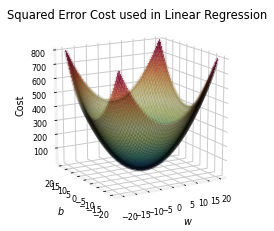

In [29]:
soup_bowl()

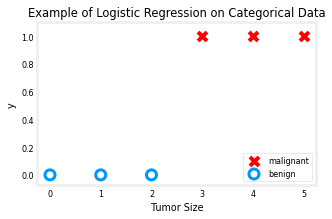

In [30]:
x_train = np.array([0., 1, 2, 3, 4, 5],dtype=np.longdouble)
y_train = np.array([0,  0, 0, 1, 1, 1],dtype=np.longdouble)
plt_simple_example(x_train, y_train)

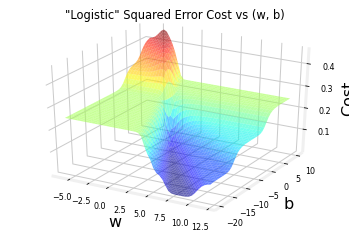

In [31]:
plt.close('all')
plt_logistic_squared_error(x_train,y_train)
plt.show()

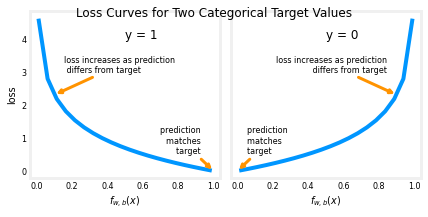

In [32]:
plt_two_logistic_loss_curves()

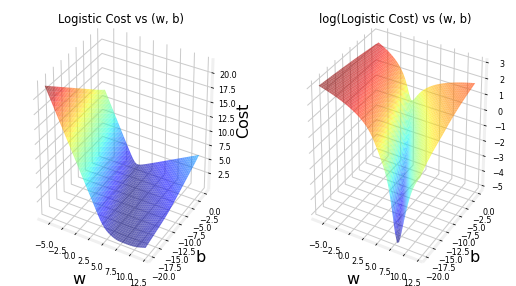

In [33]:
plt.close('all')
cst = plt_logistic_cost(x_train,y_train)

In [34]:
# Cost Function for Logistic Regression

In [35]:
import numpy as np
import matplotlib.pyplot as plt

In [36]:
X_train = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])  #(m,n)
y_train = np.array([0, 0, 0, 1, 1, 1])   

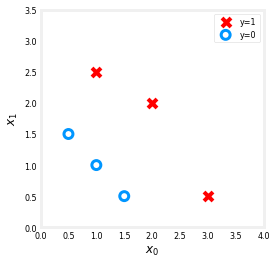

In [37]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_data(X_train, y_train, ax)

# Set both axes to be from 0-4
ax.axis([0, 4, 0, 3.5])
ax.set_ylabel('$x_1$', fontsize=12)
ax.set_xlabel('$x_0$', fontsize=12)
plt.show()

In [38]:
def compute_cost_logistic(X, y, w, b):
    """
    Computes cost

    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """

    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        z_i = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z_i)
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)
             
    cost = cost / m
    return cost


In [39]:
w_tmp = np.array([1,1])
b_tmp = -3
print(compute_cost_logistic(X_train, y_train, w_tmp, b_tmp))

0.36686678640551745


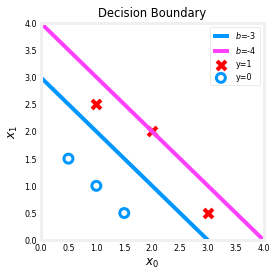

In [40]:
import matplotlib.pyplot as plt

# Choose values between 0 and 6
x0 = np.arange(0,6)

# Plot the two decision boundaries
x1 = 3 - x0
x1_other = 4 - x0

fig,ax = plt.subplots(1, 1, figsize=(4,4))
# Plot the decision boundary
ax.plot(x0,x1, c=dlc["dlblue"], label="$b$=-3")
ax.plot(x0,x1_other, c=dlc["dlmagenta"], label="$b$=-4")
ax.axis([0, 4, 0, 4])

# Plot the original data
plot_data(X_train,y_train,ax)
ax.axis([0, 4, 0, 4])
ax.set_ylabel('$x_1$', fontsize=12)
ax.set_xlabel('$x_0$', fontsize=12)
plt.legend(loc="upper right")
plt.title("Decision Boundary")
plt.show()

In [41]:
w_array1 = np.array([1,1])
b_1 = -3
w_array2 = np.array([1,1])
b_2 = -4

print("Cost for b = -3 : ", compute_cost_logistic(X_train, y_train, w_array1, b_1))
print("Cost for b = -4 : ", compute_cost_logistic(X_train, y_train, w_array2, b_2))

Cost for b = -3 :  0.36686678640551745
Cost for b = -4 :  0.5036808636748461


In [42]:
# Logistic Regression using Scikit-Learn

In [43]:
import numpy as np

X = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y = np.array([0, 0, 0, 1, 1, 1])

In [44]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X, y)

LogisticRegression()

In [45]:
y_pred = lr_model.predict(X)

print("Prediction on training set:", y_pred)

Prediction on training set: [0 0 0 1 1 1]


In [46]:
print("Accuracy on training set:", lr_model.score(X, y))

Accuracy on training set: 1.0


In [50]:
# plt_overfit.py

"""
plot_overfit
    class and assocaited routines that plot an interactive example of overfitting and its solutions
"""
import math
from ipywidgets import Output
from matplotlib.gridspec import GridSpec
from matplotlib.widgets import Button, CheckButtons
from sklearn.linear_model import LogisticRegression, Ridge

def map_one_feature(X1, degree):
    """
    Feature mapping function to polynomial features
    """
    X1 = np.atleast_1d(X1)
    out = []
    string = ""
    k = 0
    for i in range(1, degree+1):
        out.append((X1**i))
        string = string + f"w_{{{k}}}{munge('x_0',i)} + "
        k += 1
    string = string + ' b' #add b to text equation, not to data
    return np.stack(out, axis=1), string


def map_feature(X1, X2, degree):
    """
    Feature mapping function to polynomial features
    """
    X1 = np.atleast_1d(X1)
    X2 = np.atleast_1d(X2)

    out = []
    string = ""
    k = 0
    for i in range(1, degree+1):
        for j in range(i + 1):
            out.append((X1**(i-j) * (X2**j)))
            string = string + f"w_{{{k}}}{munge('x_0',i-j)}{munge('x_1',j)} + "
            k += 1
    #print(string + 'b')
    return np.stack(out, axis=1), string + ' b'

def munge(base, exp):
    if exp == 0:
        return ''
    if exp == 1:
        return base
    return base + f'^{{{exp}}}'

def plot_decision_boundary(ax, x0r,x1r, predict,  w, b, scaler = False, mu=None, sigma=None, degree=None):
    """
    Plots a decision boundary
     Args:
      x0r : (array_like Shape (1,1)) range (min, max) of x0
      x1r : (array_like Shape (1,1)) range (min, max) of x1
      predict : function to predict z values
      scalar : (boolean) scale data or not
    """

    h = .01  # step size in the mesh
    # create a mesh to plot in
    xx, yy = np.meshgrid(np.arange(x0r[0], x0r[1], h),
                         np.arange(x1r[0], x1r[1], h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    points = np.c_[xx.ravel(), yy.ravel()]
    Xm,_ = map_feature(points[:, 0], points[:, 1],degree)
    if scaler:
        Xm = (Xm - mu)/sigma
    Z = predict(Xm, w, b)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    contour = ax.contour(xx, yy, Z, levels = [0.5], colors='g')
    return contour

# use this to test the above routine
def plot_decision_boundary_sklearn(x0r, x1r, predict, degree,  scaler = False):
    """
    Plots a decision boundary
     Args:
      x0r : (array_like Shape (1,1)) range (min, max) of x0
      x1r : (array_like Shape (1,1)) range (min, max) of x1
      degree: (int)                  degree of polynomial
      predict : function to predict z values
      scaler  : not sure
    """

    h = .01  # step size in the mesh
    # create a mesh to plot in
    xx, yy = np.meshgrid(np.arange(x0r[0], x0r[1], h),
                         np.arange(x1r[0], x1r[1], h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    points = np.c_[xx.ravel(), yy.ravel()]
    Xm = map_feature(points[:, 0], points[:, 1],degree)
    if scaler:
        Xm = scaler.transform(Xm)
    Z = predict(Xm)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='g')
    #plot_data(X_train,y_train)

#for debug, uncomment the #@output statments below for routines you want to get error output from
# In the notebook that will call these routines, import  `output`
# from plt_overfit import overfit_example, output
# then, in a cell where the error messages will be the output of..
#display(output)

output = Output() # sends hidden error messages to display when using widgets

class button_manager:
    ''' Handles some missing features of matplotlib check buttons
    on init:
        creates button, links to button_click routine,
        calls call_on_click with active index and firsttime=True
    on click:
        maintains single button on state, calls call_on_click
    '''

    @output.capture()  # debug
    def __init__(self,fig, dim, labels, init, call_on_click):
        '''
        dim: (list)     [leftbottom_x,bottom_y,width,height]
        labels: (list)  for example ['1','2','3','4','5','6']
        init: (list)    for example [True, False, False, False, False, False]
        '''
        self.fig = fig
        self.ax = plt.axes(dim)  #lx,by,w,h
        self.init_state = init
        self.call_on_click = call_on_click
        self.button  = CheckButtons(self.ax,labels,init)
        self.button.on_clicked(self.button_click)
        self.status = self.button.get_status()
        self.call_on_click(self.status.index(True),firsttime=True)

    @output.capture()  # debug
    def reinit(self):
        self.status = self.init_state
        self.button.set_active(self.status.index(True))      #turn off old, will trigger update and set to status

    @output.capture()  # debug
    def button_click(self, event):
        ''' maintains one-on state. If on-button is clicked, will process correctly '''
        #new_status = self.button.get_status()
        #new = [self.status[i] ^ new_status[i] for i in range(len(self.status))]
        #newidx = new.index(True)
        self.button.eventson = False
        self.button.set_active(self.status.index(True))  #turn off old or reenable if same
        self.button.eventson = True
        self.status = self.button.get_status()
        self.call_on_click(self.status.index(True))

class overfit_example():
    """ plot overfit example """
    # pylint: disable=too-many-instance-attributes
    # pylint: disable=too-many-locals
    # pylint: disable=missing-function-docstring
    # pylint: disable=attribute-defined-outside-init
    def __init__(self, regularize=False):
        self.regularize=regularize
        self.lambda_=0
        fig = plt.figure( figsize=(8,6))
        fig.canvas.toolbar_visible = False
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False
        fig.set_facecolor('#ffffff') #white
        gs  = GridSpec(5, 3, figure=fig)
        ax0 = fig.add_subplot(gs[0:3, :])
        ax1 = fig.add_subplot(gs[-2, :])
        ax2 = fig.add_subplot(gs[-1, :])
        ax1.set_axis_off()
        ax2.set_axis_off()
        self.ax = [ax0,ax1,ax2]
        self.fig = fig

        self.axfitdata = plt.axes([0.26,0.124,0.12,0.1 ])  #lx,by,w,h
        self.bfitdata  = Button(self.axfitdata , 'fit data', color=dlc['dlblue'])
        self.bfitdata.label.set_fontsize(12)
        self.bfitdata.on_clicked(self.fitdata_clicked)

        #clear data is a future enhancement
        #self.axclrdata = plt.axes([0.26,0.06,0.12,0.05 ])  #lx,by,w,h
        #self.bclrdata  = Button(self.axclrdata , 'clear data', color='white')
        #self.bclrdata.label.set_fontsize(12)
        #self.bclrdata.on_clicked(self.clrdata_clicked)

        self.cid = fig.canvas.mpl_connect('button_press_event', self.add_data)

        self.typebut = button_manager(fig, [0.4, 0.07,0.15,0.15], ["Regression", "Categorical"],
                                       [False,True], self.toggle_type)

        self.fig.text(0.1, 0.02+0.21, "Degree", fontsize=12)
        self.degrbut = button_manager(fig,[0.1,0.02,0.15,0.2 ], ['1','2','3','4','5','6'],
                                        [True, False, False, False, False, False], self.update_equation)
        if self.regularize:
            self.fig.text(0.6, 0.02+0.21, r"lambda($\lambda$)", fontsize=12)
            self.lambut = button_manager(fig,[0.6,0.02,0.15,0.2 ], ['0.0','0.2','0.4','0.6','0.8','1'],
                                        [True, False, False, False, False, False], self.updt_lambda)

        #self.regbut =  button_manager(fig, [0.8, 0.08,0.24,0.15], ["Regularize"],
        #                               [False], self.toggle_reg)
        #self.logistic_data()

    def updt_lambda(self, idx, firsttime=False):
      # pylint: disable=unused-argument
        self.lambda_ = idx * 0.2

    def toggle_type(self, idx, firsttime=False):
        self.logistic = idx==1
        self.ax[0].clear()
        if self.logistic:
            self.logistic_data()
        else:
            self.linear_data()
        if not firsttime:
            self.degrbut.reinit()

    @output.capture()  # debug
    def logistic_data(self,redraw=False):
        if not redraw:
            m = 50
            n = 2
            np.random.seed(2)
            X_train = 2*(np.random.rand(m,n)-[0.5,0.5])
            y_train = X_train[:,1]+0.5  > X_train[:,0]**2 + 0.5*np.random.rand(m) #quadratic + random
            y_train = y_train + 0  #convert from boolean to integer
            self.X = X_train
            self.y = y_train
            self.x_ideal = np.sort(X_train[:,0])
            self.y_ideal =  self.x_ideal**2


        self.ax[0].plot(self.x_ideal, self.y_ideal, "--", color = "orangered", label="ideal", lw=1)
        plot_data(self.X, self.y, self.ax[0], s=10, loc='lower right')
        self.ax[0].set_title("OverFitting Example: Categorical data set with noise")
        self.ax[0].text(0.5,0.93, "Click on plot to add data. Hold [Shift] for blue(y=0) data.",
                        fontsize=12, ha='center',transform=self.ax[0].transAxes, color=dlc["dlblue"])
        self.ax[0].set_xlabel(r"$x_0$")
        self.ax[0].set_ylabel(r"$x_1$")

    def linear_data(self,redraw=False):
        if not redraw:
            m = 30
            c = 0
            x_train = np.arange(0,m,1)
            np.random.seed(1)
            y_ideal = x_train**2 + c
            y_train = y_ideal + 0.7 * y_ideal*(np.random.sample((m,))-0.5)
            self.x_ideal = x_train #for redraw when new data included in X
            self.X = x_train
            self.y = y_train
            self.y_ideal = y_ideal
        else:
            self.ax[0].set_xlim(self.xlim)
            self.ax[0].set_ylim(self.ylim)

        self.ax[0].scatter(self.X,self.y, label="y")
        self.ax[0].plot(self.x_ideal, self.y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
        self.ax[0].set_title("OverFitting Example: Regression Data Set (quadratic with noise)",fontsize = 14)
        self.ax[0].set_xlabel("x")
        self.ax[0].set_ylabel("y")
        self.ax0ledgend = self.ax[0].legend(loc='lower right')
        self.ax[0].text(0.5,0.93, "Click on plot to add data",
                        fontsize=12, ha='center',transform=self.ax[0].transAxes, color=dlc["dlblue"])
        if not redraw:
            self.xlim = self.ax[0].get_xlim()
            self.ylim = self.ax[0].get_ylim()


    @output.capture()  # debug
    def add_data(self, event):
        if self.logistic:
            self.add_data_logistic(event)
        else:
            self.add_data_linear(event)

    @output.capture()  # debug
    def add_data_logistic(self, event):
        if event.inaxes == self.ax[0]:
            x0_coord = event.xdata
            x1_coord = event.ydata

            if event.key is None:  #shift not pressed
                self.ax[0].scatter(x0_coord, x1_coord, marker='x', s=10, c = 'red', label="y=1")
                self.y = np.append(self.y,1)
            else:
                self.ax[0].scatter(x0_coord, x1_coord, marker='o', s=10, label="y=0", facecolors='none',
                                   edgecolors=dlc['dlblue'],lw=3)
                self.y = np.append(self.y,0)
            self.X = np.append(self.X,np.array([[x0_coord, x1_coord]]),axis=0)
        self.fig.canvas.draw()

    def add_data_linear(self, event):
        if event.inaxes == self.ax[0]:
            x_coord = event.xdata
            y_coord = event.ydata

            self.ax[0].scatter(x_coord, y_coord, marker='o', s=10, facecolors='none',
                                   edgecolors=dlc['dlblue'],lw=3)
            self.y = np.append(self.y,y_coord)
            self.X = np.append(self.X,x_coord)
            self.fig.canvas.draw()

    #@output.capture()  # debug
    #def clrdata_clicked(self,event):
    #    if self.logistic == True:
    #        self.X = np.
    #    else:
    #        self.linear_regression()


    @output.capture()  # debug
    def fitdata_clicked(self,event):
        if self.logistic:
            self.logistic_regression()
        else:
            self.linear_regression()

    def linear_regression(self):
        self.ax[0].clear()
        self.fig.canvas.draw()

        # create and fit the model using our mapped_X feature set.
        self.X_mapped, _ =  map_one_feature(self.X, self.degree)
        self.X_mapped_scaled, self.X_mu, self.X_sigma  = zscore_normalize_features(self.X_mapped)

        #linear_model = LinearRegression()
        linear_model = Ridge(alpha=self.lambda_, normalize=True, max_iter=10000)
        linear_model.fit(self.X_mapped_scaled, self.y )
        self.w = linear_model.coef_.reshape(-1,)
        self.b = linear_model.intercept_
        x = np.linspace(*self.xlim,30)  #plot line idependent of data which gets disordered
        xm, _ =  map_one_feature(x, self.degree)
        xms = (xm - self.X_mu)/ self.X_sigma
        y_pred = linear_model.predict(xms)

        #self.fig.canvas.draw()
        self.linear_data(redraw=True)
        self.ax0yfit = self.ax[0].plot(x, y_pred, color = "blue", label="y_fit")
        self.ax0ledgend = self.ax[0].legend(loc='lower right')
        self.fig.canvas.draw()

    def logistic_regression(self):
        self.ax[0].clear()
        self.fig.canvas.draw()

        # create and fit the model using our mapped_X feature set.
        self.X_mapped, _ =  map_feature(self.X[:, 0], self.X[:, 1], self.degree)
        self.X_mapped_scaled, self.X_mu, self.X_sigma  = zscore_normalize_features(self.X_mapped)
        if not self.regularize or self.lambda_ == 0:
            lr = LogisticRegression(penalty='none', max_iter=10000)
        else:
            C = 1/self.lambda_
            lr = LogisticRegression(C=C, max_iter=10000)

        lr.fit(self.X_mapped_scaled,self.y)
        #print(lr.score(self.X_mapped_scaled, self.y))
        self.w = lr.coef_.reshape(-1,)
        self.b = lr.intercept_
        #print(self.w, self.b)
        self.logistic_data(redraw=True)
        self.contour = plot_decision_boundary(self.ax[0],[-1,1],[-1,1], predict_logistic, self.w, self.b,
                       scaler=True, mu=self.X_mu, sigma=self.X_sigma, degree=self.degree )
        self.fig.canvas.draw()

    @output.capture()  # debug
    def update_equation(self, idx, firsttime=False):
        #print(f"Update equation, index = {idx}, firsttime={firsttime}")
        self.degree = idx+1
        if firsttime:
            self.eqtext = []
        else:
            for artist in self.eqtext:
                #print(artist)
                artist.remove()
            self.eqtext = []
        if self.logistic:
            _, equation =  map_feature(self.X[:, 0], self.X[:, 1], self.degree)
            string = 'f_{wb} = sigmoid('
        else:
            _, equation =  map_one_feature(self.X, self.degree)
            string = 'f_{wb} = ('
        bz = 10
        seq = equation.split('+')
        blks = math.ceil(len(seq)/bz)
        for i in range(blks):
            if i == 0:
                string = string +  '+'.join(seq[bz*i:bz*i+bz])
            else:
                string = '+'.join(seq[bz*i:bz*i+bz])
            string = string + ')' if i == blks-1 else string + '+'
            ei = self.ax[1].text(0.01,(0.75-i*0.25), f"${string}$",fontsize=9,
                                 transform = self.ax[1].transAxes, ma='left', va='top' )
            self.eqtext.append(ei)
        self.fig.canvas.draw()


In [51]:
# Overfitting

In [ ]:
from ipywidgets import Output

Output()

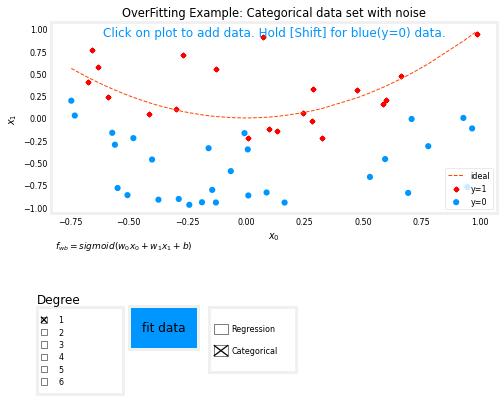

In [53]:
plt.close("all")
display(output)
ofit = overfit_example(False)

In [54]:
# Regularized Cost and Gradient

In [55]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=8)

In [56]:
def compute_cost_linear_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
      lambda_ (scalar): Controls amount of regularization
    Returns:
      total_cost (scalar):  cost 
    """

    m  = X.shape[0]
    n  = len(w)
    cost = 0.
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b                                   #(n,)(n,)=scalar, see np.dot
        cost = cost + (f_wb_i - y[i])**2                               #scalar             
    cost = cost / (2 * m)                                              #scalar  
 
    reg_cost = 0
    for j in range(n):
        reg_cost += (w[j]**2)                                          #scalar
    reg_cost = (lambda_/(2*m)) * reg_cost                              #scalar
    
    total_cost = cost + reg_cost                                       #scalar
    return total_cost                                                  #scalar

In [57]:
def compute_cost_logistic_reg(X, y, w, b, lambda_ = 1):
    """
    Computes the cost over all examples
    Args:
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
      lambda_ (scalar): Controls amount of regularization
    Returns:
      total_cost (scalar):  cost 
    """

    m,n  = X.shape
    cost = 0.
    for i in range(m):
        z_i = np.dot(X[i], w) + b                                      #(n,)(n,)=scalar, see np.dot
        f_wb_i = sigmoid(z_i)                                          #scalar
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)      #scalar
             
    cost = cost/m                                                      #scalar

    reg_cost = 0
    for j in range(n):
        reg_cost += (w[j]**2)                                          #scalar
    reg_cost = (lambda_/(2*m)) * reg_cost                              #scalar
    
    total_cost = cost + reg_cost                                       #scalar
    return total_cost                                                  #scalar

In [58]:
np.random.seed(1)
X_tmp = np.random.rand(5,6)
y_tmp = np.array([0,1,0,1,0])
w_tmp = np.random.rand(X_tmp.shape[1]).reshape(-1,)-0.5
b_tmp = 0.5
lambda_tmp = 0.7
cost_tmp = compute_cost_logistic_reg(X_tmp, y_tmp, w_tmp, b_tmp, lambda_tmp)

print("Regularized cost:", cost_tmp)

Regularized cost: 0.6850849138741673


In [59]:
def compute_gradient_linear_reg(X, y, w, b, lambda_): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
      lambda_ (scalar): Controls amount of regularization
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]                 
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err * X[i, j]               
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m   
    
    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_/m) * w[j]

    return dj_db, dj_dw

In [60]:
np.random.seed(1)
X_tmp = np.random.rand(5,3)
y_tmp = np.array([0,1,0,1,0])
w_tmp = np.random.rand(X_tmp.shape[1])
b_tmp = 0.5
lambda_tmp = 0.7
dj_db_tmp, dj_dw_tmp =  compute_gradient_linear_reg(X_tmp, y_tmp, w_tmp, b_tmp, lambda_tmp)

print(f"dj_db: {dj_db_tmp}", )
print(f"Regularized dj_dw:\n {dj_dw_tmp.tolist()}", )

dj_db: 0.6648774569425726
Regularized dj_dw:
 [0.29653214748822276, 0.4911679625918033, 0.21645877535865857]


In [61]:
def compute_gradient_logistic_reg(X, y, w, b, lambda_): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
      lambda_ (scalar): Controls amount of regularization
    Returns
      dj_dw (ndarray Shape (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)            : The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape
    dj_dw = np.zeros((n,))                            #(n,)
    dj_db = 0.0                                       #scalar

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar

    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_/m) * w[j]

    return dj_db, dj_dw  


In [62]:
np.random.seed(1)
X_tmp = np.random.rand(5,3)
y_tmp = np.array([0,1,0,1,0])
w_tmp = np.random.rand(X_tmp.shape[1])
b_tmp = 0.5
lambda_tmp = 0.7
dj_db_tmp, dj_dw_tmp =  compute_gradient_logistic_reg(X_tmp, y_tmp, w_tmp, b_tmp, lambda_tmp)

print(f"dj_db: {dj_db_tmp}", )
print(f"Regularized dj_dw:\n {dj_dw_tmp.tolist()}", )

dj_db: 0.341798994972791
Regularized dj_dw:
 [0.17380012933994293, 0.32007507881566943, 0.10776313396851499]


Output()

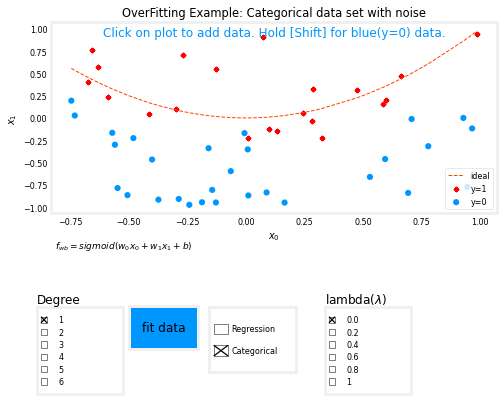

In [63]:
plt.close("all")
display(output)
ofit = overfit_example(True)